# 外交青書2025 テキストマイニング分析

## 概要

このノートブックでは、外務省が発行する「外交青書2025」第1章「国際情勢認識と日本外交の展望」のPDFファイルに対して、テキストマイニング分析を行います。

### 分析内容

1. **PDFからのテキスト抽出** - pdfplumberを使用してPDFからテキストデータを抽出
2. **形態素解析** - Janomeを使用して日本語テキストを単語に分解
3. **単語頻度分析** - 出現頻度の高い単語を特定
4. **共起分析** - 同時に出現する単語ペアを分析し、ネットワークで可視化
5. **ワードクラウド生成** - 分析結果を視覚化

### 使用ライブラリ

| ライブラリ | 用途 |
|-----------|------|
| pdfplumber | PDFからテキスト抽出 |
| Janome | 日本語形態素解析 |
| wordcloud | ワードクラウド生成 |
| matplotlib | グラフ・画像表示 |
| networkx | 共起ネットワーク可視化 |

### 形態素解析とは

形態素解析は、自然言語処理（NLP）の基礎技術の一つで、文章を意味を持つ最小単位（形態素）に分解する処理です。日本語は英語と異なり単語間にスペースがないため、形態素解析が特に重要です。

例：「国際社会は転換点にある」→「国際」「社会」「は」「転換」「点」「に」「ある」

### ストップワードについて

ストップワードとは、分析から除外する一般的な単語のことです。「こと」「もの」「する」などの機能語は、どの文書にも頻出するため、文書の特徴を把握する上でノイズとなります。本分析では、これらを除外して内容語（名詞・動詞・形容詞）に焦点を当てます。

### 共起分析とは

共起分析は、テキスト内で同時に出現する単語のペアを分析する手法です。どの単語同士が一緒に使われやすいかを明らかにし、文書のトピックや単語間の関連性を把握するのに役立ちます。

---
## 1. 環境設定

必要なライブラリをインポートします。未インストールの場合は、以下のコマンドでインストールしてください：

```bash
pip install pdfplumber janome wordcloud matplotlib japanize-matplotlib networkx
```

In [1]:
# 必要なライブラリのインポート
import re
import csv
from collections import Counter
from pathlib import Path

# PDF読み込み
import pdfplumber

# 形態素解析
from janome.tokenizer import Tokenizer

# 可視化
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 日本語フォントを検索して設定
def setup_japanese_font():
    """利用可能な日本語フォントを設定"""
    # フォントキャッシュを再構築
    fm._load_fontmanager(try_read_cache=False)
    
    # 日本語フォントを探す
    jp_font_names = ['Noto Sans CJK JP', 'Noto Sans CJK', 'IPAGothic', 'IPAexGothic', 
                     'TakaoPGothic', 'VL Gothic', 'Hiragino Sans']
    
    available_fonts = set([f.name for f in fm.fontManager.ttflist])
    
    for font_name in jp_font_names:
        if font_name in available_fonts:
            plt.rcParams['font.family'] = font_name
            print(f"日本語フォント設定: {font_name}")
            return font_name
    
    print("警告: 日本語フォントが見つかりません")
    return None

# フォント設定を実行
setup_japanese_font()
plt.rcParams['axes.unicode_minus'] = False

# Jupyter Notebook用の設定
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

print("ライブラリのインポート完了")

日本語フォント設定: Noto Sans CJK JP
ライブラリのインポート完了


---
## 2. 設定とパラメータ

分析に使用する各種パラメータを定義します。

In [2]:
# ===== 入出力ファイルの設定 =====
PDF_PATH = "1_2_1.pdf"  # 入力PDFファイル
OUTPUT_CSV = "word_frequency_results.csv"  # 頻度分析結果の出力先
OUTPUT_IMAGE = "wordcloud.png"  # ワードクラウド画像の出力先

# ===== 形態素解析の設定 =====
# 抽出対象の品詞
TARGET_POS = ['名詞', '動詞', '形容詞']

# ストップワード（除外する一般的な単語）
STOPWORDS = {
    # 形式名詞
    'こと', 'もの', 'ため', 'よう',
    # 代名詞
    'これ', 'それ', 'あれ', 'ここ', 'そこ', 'あそこ', 
    'どこ', 'どれ', 'なに', '何',
    # 補助動詞・基本動詞
    'する', 'いる', 'ある', 'なる', 'れる', 'られる', 'せる',
    'できる', 'おる', 'くる', '来る', '行く', 'いく',
    # 指示詞
    'この', 'その', 'あの', 'どの', 
    # 否定
    'ない', 'なく',
    # 接尾辞
    '等', '的', '化', '性', '上', '中', '下', '内', '外',
    # 時間・番号
    '年', '月', '日', '号', '第', '章',
    # 接続詞等
    'ほか', 'また', 'および', 'かつ', 'ただし', 'なお', 'または'
}

# ===== ワードクラウドの設定 =====
WORDCLOUD_CONFIG = {
    'width': 1200,
    'height': 800,
    'background_color': 'white',
    'max_words': 100,
    'max_font_size': 150,
    'min_font_size': 10,
    'colormap': 'viridis',
    'prefer_horizontal': 0.7,
    'relative_scaling': 0.5,
    'random_state': 42
}

print(f"対象PDF: {PDF_PATH}")
print(f"抽出品詞: {TARGET_POS}")
print(f"ストップワード数: {len(STOPWORDS)}語")

対象PDF: 1_2_1.pdf
抽出品詞: ['名詞', '動詞', '形容詞']
ストップワード数: 55語


---
## 3. PDFからテキスト抽出

pdfplumberを使用してPDFファイルからテキストを抽出します。

In [3]:
def extract_text_from_pdf(pdf_path: str) -> str:
    """
    PDFファイルからテキストを抽出する
    
    Parameters:
        pdf_path: PDFファイルのパス
    
    Returns:
        抽出されたテキスト
    """
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        print(f"総ページ数: {len(pdf.pages)}")
        for i, page in enumerate(pdf.pages, 1):
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
                print(f"  ページ {i}: {len(page_text):,} 文字抽出")
    return text

# テキスト抽出の実行
print("PDFからテキストを抽出中...\n")
raw_text = extract_text_from_pdf(PDF_PATH)
print(f"\n合計抽出文字数: {len(raw_text):,} 文字")

PDFからテキストを抽出中...

総ページ数: 4
  ページ 1: 1,383 文字抽出
  ページ 2: 1,786 文字抽出


  ページ 3: 1,738 文字抽出


  ページ 4: 1,636 文字抽出

合計抽出文字数: 6,547 文字


In [4]:
# 抽出したテキストの先頭部分を確認
print("=" * 60)
print("抽出テキスト（先頭500文字）")
print("=" * 60)
print(raw_text[:500])

抽出テキスト（先頭500文字）
第1章 国際情勢認識と日本外交の展望
11
第第 章章 国際情勢認識と日本外交の展望
日本が外交安全保障及び経済上の国益を確保 要がある。このためには、国際情勢の潮流を冷
し、また、危機を未然に防ぎ、海外在留邦人を 静に把握し、変化に適応しながら、戦略的・機
含む国民の生活の安全と繁栄を確保するために 動的に外交を展開していくことが求められる。
は、自由、民主主義、人権、法の支配といった 本章では、日本を取り巻く国際情勢認識及び
価値や原則に基づく国際秩序を維持・強化し、 日本外交の展望について概観する。
平和で安定した国際環境を能動的に創出する必
11 情勢認識
現在、国際社会は再び歴史の大きな転換点に さらに、一部の国家は、急速かつ不透明な軍
ある。冷戦後の一定期間、安定的な国際秩序が 事力の強化を進め、独自の歴史観に基づき既存
世界に拡大した。圧倒的な国力を有する米国 の国際秩序に対する挑戦的姿勢と自己主張を強
と、日本を含む先進民主主義国が自由、民主主 めているほか、経済的な依存関係を自らの政治
義、基本的人権の尊重、法の支配などの価値や 的目的の実現のために「武器化」するとい


---
## 4. テキストの前処理（クリーニング）

形態素解析の精度を高めるため、テキストから不要な文字（数字、英字、記号など）を除去します。

In [5]:
def clean_text(text: str) -> str:
    """
    テキストをクリーニングする
    
    Parameters:
        text: 入力テキスト
    
    Returns:
        クリーニング後のテキスト
    """
    # 数字を除去（半角・全角）
    text = re.sub(r'[0-9０-９]+', '', text)
    
    # 英字を除去（半角・全角）
    text = re.sub(r'[a-zA-Zａ-ｚＡ-Ｚ]+', '', text)
    
    # 記号・空白をスペースに置換
    text = re.sub(r'[（）()【】「」『』・、。：；！？\s\n]+', ' ', text)
    
    # 日本語以外の文字を除去（ひらがな・カタカナ・漢字以外）
    text = re.sub(r'[^\u3040-\u309F\u30A0-\u30FF\u4E00-\u9FFF\s]', '', text)
    
    return text

# クリーニングの実行
cleaned_text = clean_text(raw_text)

print(f"クリーニング前: {len(raw_text):,} 文字")
print(f"クリーニング後: {len(cleaned_text):,} 文字")
print(f"削減率: {(1 - len(cleaned_text)/len(raw_text))*100:.1f}%")

クリーニング前: 6,547 文字
クリーニング後: 6,170 文字
削減率: 5.8%


---
## 5. 形態素解析

Janomeを使用して日本語テキストを形態素（単語）に分解します。

### 品詞の種類

| 品詞 | 説明 | 例 |
|------|------|----|
| 名詞 | 物事の名前 | 国際、社会、経済 |
| 動詞 | 動作・状態 | 進む、変化する |
| 形容詞 | 性質・状態 | 重要、厳しい |

In [6]:
def analyze_morphology(text: str, target_pos: list, stopwords: set) -> list:
    """
    形態素解析を実行し、指定した品詞の単語を抽出する
    
    Parameters:
        text: 解析対象のテキスト
        target_pos: 抽出対象の品詞リスト
        stopwords: 除外する単語のセット
    
    Returns:
        抽出された単語のリスト
    """
    tokenizer = Tokenizer()
    words = []
    
    for token in tokenizer.tokenize(text):
        # 品詞情報を取得
        pos = token.part_of_speech.split(',')[0]  # 品詞の大分類
        pos_detail = token.part_of_speech.split(',')[1] if ',' in token.part_of_speech else ''
        
        # 指定した品詞かどうかチェック
        if pos not in target_pos:
            continue
        
        # 名詞の場合、非自立・代名詞・数は除外
        if pos == '名詞' and pos_detail in ['非自立', '代名詞', '数']:
            continue
        
        # 基本形を取得（活用形の場合は原形に変換）
        word = token.base_form if token.base_form != '*' else token.surface
        
        # 1文字の単語とストップワードを除外
        if len(word) > 1 and word not in stopwords:
            words.append(word)
    
    return words

# 形態素解析の実行
print("形態素解析を実行中...")
words = analyze_morphology(cleaned_text, TARGET_POS, STOPWORDS)

print(f"\n抽出単語数: {len(words):,} 語")
print(f"ユニーク単語数: {len(set(words)):,} 語")

形態素解析を実行中...



抽出単語数: 1,387 語
ユニーク単語数: 586 語


In [7]:
# 形態素解析の結果サンプルを表示
print("抽出された単語（最初の50語）:")
print(words[:50])

抽出された単語（最初の50語）:
['国際', '情勢', '認識', '日本', '外交', '展望', '国際', '情勢', '認識', '日本', '外交', '展望', '日本', '外交', '安全', '保障', '経済', '国益', '確保', '国際', '情勢', '潮流', '危機', '未然', '防ぐ', '海外', '在留', '邦人', '把握', '変化', '適応', '戦略', '含む', '国民', '生活', '安全', '繁栄', '確保', '動的', '外交', '展開', '求める', '自由', '民主', '主義', '人権', '支配', '本章', '日本', '取り巻く']


---
## 6. 単語頻度分析

抽出した単語の出現回数をカウントし、頻度順にランキングします。

In [8]:
# 単語の出現回数をカウント
word_counts = Counter(words)

print(f"総単語数: {len(words):,} 語")
print(f"ユニーク単語数: {len(word_counts):,} 語")
print(f"\n最頻出単語: 「{word_counts.most_common(1)[0][0]}」 ({word_counts.most_common(1)[0][1]}回)")

総単語数: 1,387 語
ユニーク単語数: 586 語

最頻出単語: 「国際」 (56回)


In [9]:
# 上位30語を表形式で表示
TOP_N = 30

print("=" * 60)
print(f"単語頻度ランキング（上位{TOP_N}語）")
print("=" * 60)
print(f"{'順位':<6}{'単語':<15}{'出現回数':<10}{'グラフ'}")
print("-" * 60)

max_count = word_counts.most_common(1)[0][1]

for rank, (word, count) in enumerate(word_counts.most_common(TOP_N), 1):
    bar_length = int(count / max_count * 30)
    bar = "█" * bar_length
    print(f"{rank:<6}{word:<15}{count:<10}{bar}")

単語頻度ランキング（上位30語）
順位    単語             出現回数      グラフ
------------------------------------------------------------
1     国際             56        ██████████████████████████████
2     社会             29        ███████████████
3     経済             20        ██████████
4     日本             17        █████████
5     安全             16        ████████
6     含む             15        ████████
7     秩序             15        ████████
8     課題             15        ████████
9     重要             14        ███████
10    情勢             13        ██████
11    安定             13        ██████
12    情報             13        ██████
13    グローバル          12        ██████
14    保障             11        █████
15    求める            11        █████
16    外交             10        █████
17    世界             10        █████
18    開発             10        █████
19    平和             9         ████
20    技術             9         ████
21    ウクライナ          9         ████
22    認識             8         ████
23    基づく      

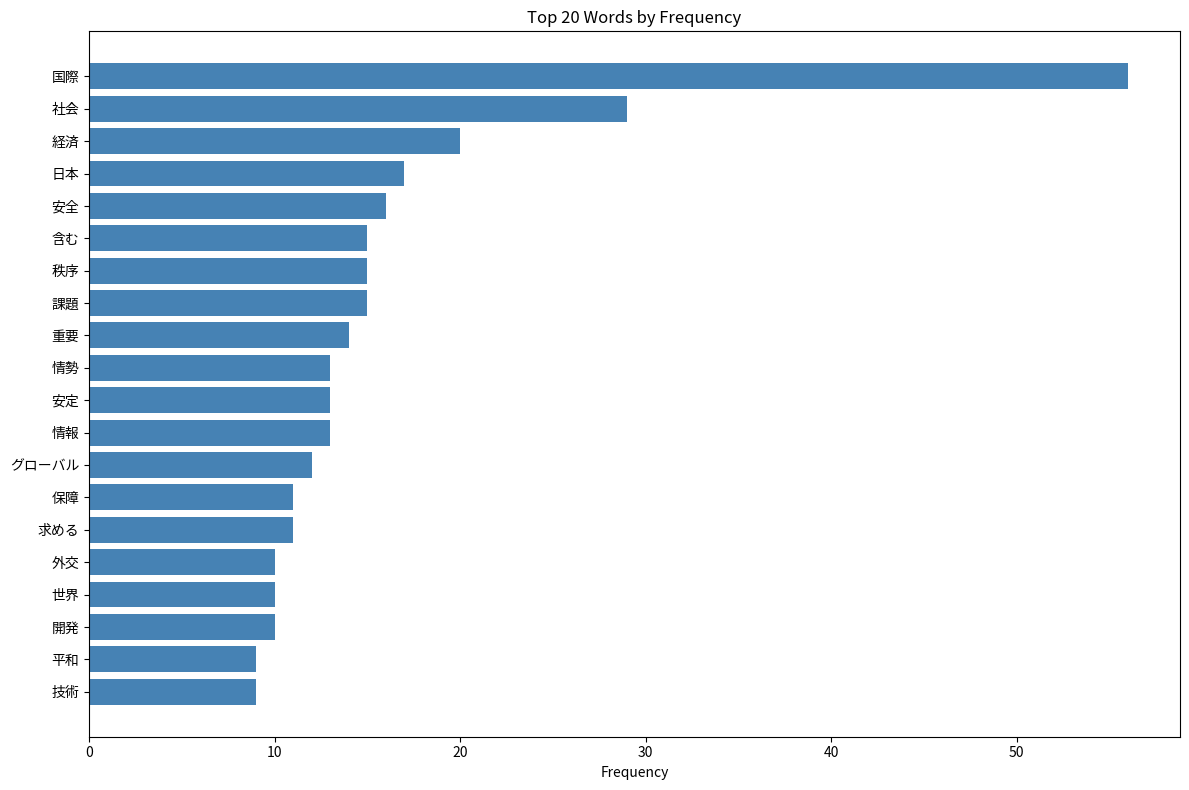

In [10]:
# 棒グラフで可視化
top_words = word_counts.most_common(20)
words_list = [w[0] for w in top_words]
counts_list = [w[1] for w in top_words]

plt.figure(figsize=(12, 8))
plt.barh(range(len(words_list)), counts_list, color='steelblue')
plt.yticks(range(len(words_list)), words_list)
plt.xlabel('Frequency')
plt.title('Top 20 Words by Frequency')
plt.gca().invert_yaxis()  # 上位を上に表示
plt.tight_layout()
plt.show()

---
## 7. 共起分析

共起分析（Co-occurrence Analysis）は、テキスト内で同時に出現する単語のペアを分析する手法です。

### 共起分析でわかること

- **単語間の関連性**: どの単語同士が一緒に使われやすいか
- **文脈の把握**: 特定の単語がどのような文脈で使われているか
- **トピックの発見**: 関連する単語のクラスターからトピックを発見

### 分析方法

1. テキストを文単位に分割
2. 各文内で同時に出現する単語ペアをカウント
3. 共起頻度の高いペアを抽出
4. ネットワークグラフで可視化

In [11]:
from itertools import combinations

def extract_sentences(text: str) -> list:
    """
    テキストを文単位に分割する
    
    Parameters:
        text: 入力テキスト
    
    Returns:
        文のリスト
    """
    # 句点で分割
    sentences = re.split(r'[。．.！？\n]+', text)
    # 空文字列を除去
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

def get_words_in_sentence(sentence: str, target_pos: list, stopwords: set, min_length: int = 2) -> list:
    """
    文から単語を抽出する
    
    Parameters:
        sentence: 入力文
        target_pos: 抽出対象の品詞
        stopwords: ストップワード
        min_length: 最小単語長
    
    Returns:
        単語のリスト（重複なし）
    """
    tokenizer = Tokenizer()
    words = set()
    
    for token in tokenizer.tokenize(sentence):
        pos = token.part_of_speech.split(',')[0]
        pos_detail = token.part_of_speech.split(',')[1] if ',' in token.part_of_speech else ''
        
        if pos not in target_pos:
            continue
        if pos == '名詞' and pos_detail in ['非自立', '代名詞', '数']:
            continue
        
        word = token.base_form if token.base_form != '*' else token.surface
        
        if len(word) >= min_length and word not in stopwords:
            words.add(word)
    
    return list(words)

# 文への分割
sentences = extract_sentences(raw_text)
print(f"抽出した文の数: {len(sentences)} 文")
print(f"\n例（最初の3文）:")
for i, sent in enumerate(sentences[:3], 1):
    print(f"  {i}. {sent[:60]}...")

抽出した文の数: 239 文

例（最初の3文）:
  1. 第1章 国際情勢認識と日本外交の展望...
  2. 11...
  3. 第第 章章 国際情勢認識と日本外交の展望...


In [12]:
def calculate_cooccurrence(sentences: list, target_pos: list, stopwords: set, 
                           top_n_words: int = 50) -> Counter:
    """
    共起頻度を計算する
    
    Parameters:
        sentences: 文のリスト
        target_pos: 抽出対象の品詞
        stopwords: ストップワード
        top_n_words: 共起分析に使用する上位単語数
    
    Returns:
        共起ペアとその頻度のCounter
    """
    # まず全体の単語頻度を計算して上位語を取得
    all_words = []
    for sent in sentences:
        words = get_words_in_sentence(sent, target_pos, stopwords)
        all_words.extend(words)
    
    top_words = set([w for w, c in Counter(all_words).most_common(top_n_words)])
    
    # 共起をカウント
    cooccurrence = Counter()
    
    for sent in sentences:
        words = get_words_in_sentence(sent, target_pos, stopwords)
        # 上位語のみにフィルタ
        words = [w for w in words if w in top_words]
        
        # 同じ文内の全ペアをカウント
        for pair in combinations(sorted(set(words)), 2):
            cooccurrence[pair] += 1
    
    return cooccurrence

# 共起分析の実行
print("共起分析を実行中...")
cooccurrence = calculate_cooccurrence(sentences, TARGET_POS, STOPWORDS, top_n_words=50)

print(f"\n共起ペア数: {len(cooccurrence):,} ペア")
print(f"\n【共起頻度 上位20ペア】")
print("=" * 50)
print(f"{'順位':<6}{'単語ペア':<30}{'共起回数'}")
print("-" * 50)

for rank, (pair, count) in enumerate(cooccurrence.most_common(20), 1):
    print(f"{rank:<6}{pair[0]} - {pair[1]:<20}{count}")

共起分析を実行中...



共起ペア数: 445 ペア

【共起頻度 上位20ペア】
順位    単語ペア                          共起回数
--------------------------------------------------
1     国際 - 社会                  24
2     国際 - 秩序                  12
3     保障 - 安全                  11
4     国際 - 情勢                  9
5     国際 - 日本                  8
6     国際 - 基づく                 7
7     基づく - 秩序                  7
8     外交 - 日本                  6
9     国際 - 安定                  6
10    含む - 国際                  6
11    国際 - 課題                  6
12    国際 - 認識                  5
13    外交 - 展望                  5
14    展望 - 日本                  5
15    情勢 - 認識                  5
16    国際 - 支配                  5
17    国際 - 発展                  5
18    依存 - 相互                  5
19    国際 - 経済                  5
20    途上 - 開発                  5


/home/katzkawai/textmining-samples/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/textmining-samples/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38555 (\N{CJK UNIFIED IDEOGRAPH-969B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/textmining-samples/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31038 (\N{CJK UNIFIED IDEOGRAPH-793E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/textmining-samples/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20250 (\N{CJK UNIFIED IDEOGRAPH-4F1A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/textmining-samples/venv/lib/python3.11/site-

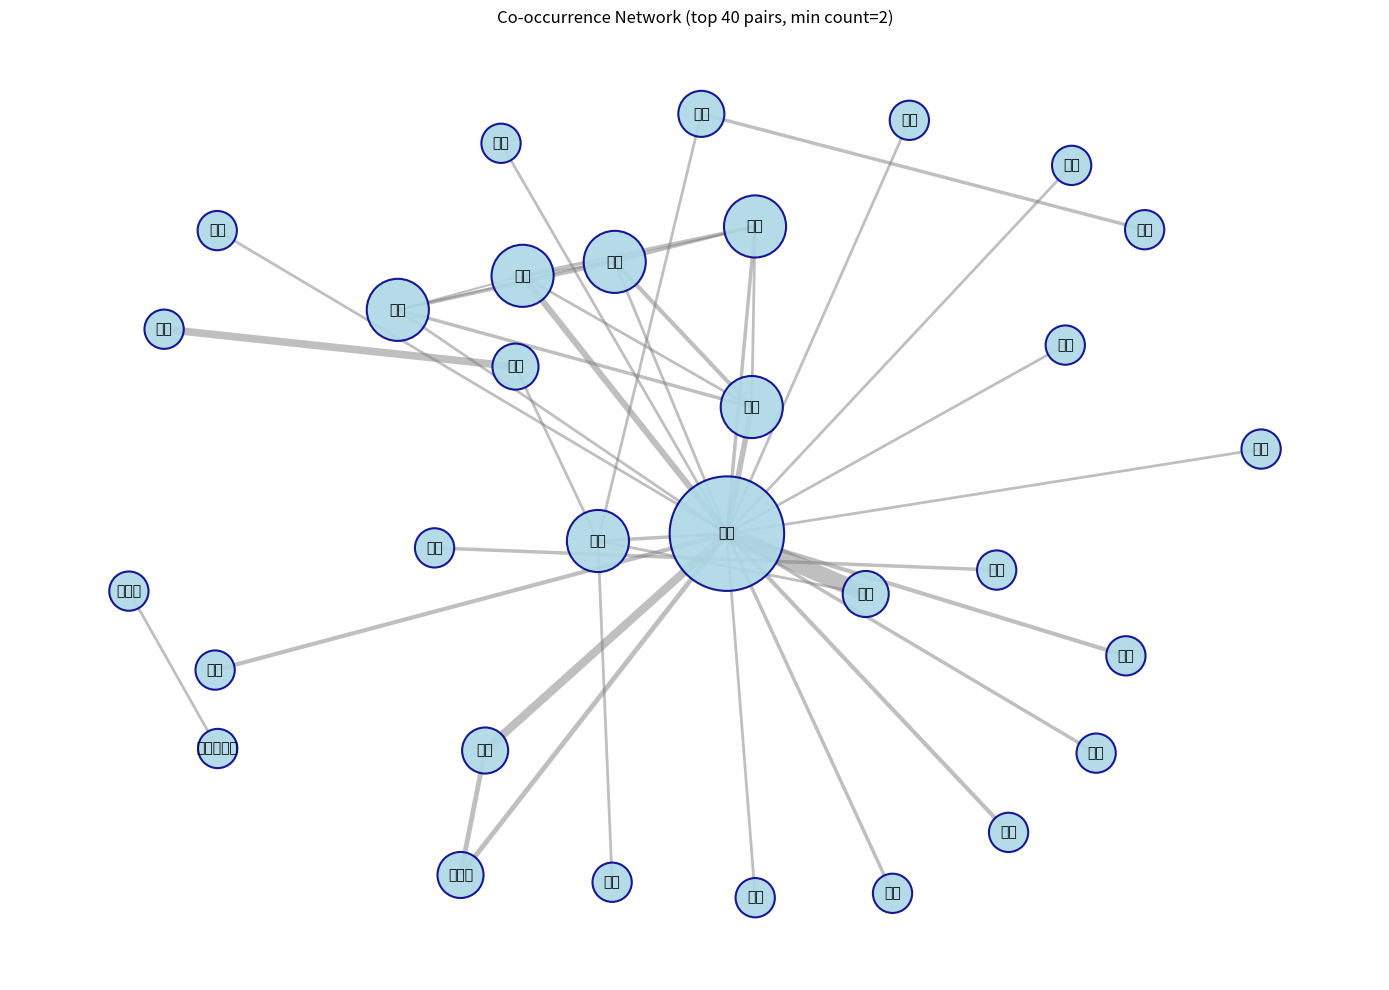


ノード数: 31
エッジ数: 40


In [13]:
# 共起ネットワークの可視化（networkxを使用）
try:
    import networkx as nx
    NETWORKX_AVAILABLE = True
except ImportError:
    NETWORKX_AVAILABLE = False
    print("networkxがインストールされていません。")
    print("pip install networkx でインストールしてください。")

if NETWORKX_AVAILABLE:
    def draw_cooccurrence_network(cooccurrence: Counter, min_count: int = 2, top_n: int = 50):
        """
        共起ネットワークを描画する
        
        Parameters:
            cooccurrence: 共起頻度のCounter
            min_count: 表示する最小共起回数
            top_n: 表示するエッジ数の上限
        """
        # グラフを作成
        G = nx.Graph()
        
        # 上位の共起ペアをエッジとして追加
        for (word1, word2), count in cooccurrence.most_common(top_n):
            if count >= min_count:
                G.add_edge(word1, word2, weight=count)
        
        if len(G.nodes()) == 0:
            print("表示するノードがありません")
            return
        
        # ノードサイズを次数に基づいて設定
        node_size = [G.degree(node) * 300 + 500 for node in G.nodes()]
        
        # エッジの太さを重みに基づいて設定
        edge_width = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]
        
        # レイアウトを計算
        pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
        
        # 描画
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # エッジを描画
        nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.5, edge_color='gray', ax=ax)
        
        # ノードを描画
        nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue', 
                               alpha=0.9, edgecolors='darkblue', linewidths=1.5, ax=ax)
        
        # ラベルを描画（日本語フォント指定）
        nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
        
        ax.set_title(f'Co-occurrence Network (top {len(G.edges())} pairs, min count={min_count})')
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        
        print(f"\nノード数: {len(G.nodes())}")
        print(f"エッジ数: {len(G.edges())}")
    
    # ネットワークを描画
    draw_cooccurrence_network(cooccurrence, min_count=2, top_n=40)

In [14]:
# 特定の単語との共起を分析
def get_cooccurrence_for_word(word: str, cooccurrence: Counter, top_n: int = 10) -> list:
    """
    特定の単語と共起する単語を取得
    
    Parameters:
        word: 対象の単語
        cooccurrence: 共起頻度のCounter
        top_n: 取得する上位数
    
    Returns:
        (共起単語, 共起回数) のリスト
    """
    related = []
    for (w1, w2), count in cooccurrence.items():
        if w1 == word:
            related.append((w2, count))
        elif w2 == word:
            related.append((w1, count))
    
    return sorted(related, key=lambda x: -x[1])[:top_n]

# 主要キーワードとの共起を分析
keywords = ['国際', '安全', '経済', 'ウクライナ', '日本']

print("=" * 60)
print("キーワード別 共起単語分析")
print("=" * 60)

for keyword in keywords:
    related = get_cooccurrence_for_word(keyword, cooccurrence, top_n=8)
    if related:
        print(f"\n【{keyword}】と共起する単語:")
        for word, count in related:
            bar = "█" * count
            print(f"  {word:<12} {count:>3}回 {bar}")

キーワード別 共起単語分析

【国際】と共起する単語:
  社会            24回 ████████████████████████
  秩序            12回 ████████████
  情勢             9回 █████████
  日本             8回 ████████
  基づく            7回 ███████
  安定             6回 ██████
  含む             6回 ██████
  課題             6回 ██████

【安全】と共起する単語:
  保障            11回 ███████████
  経済             4回 ████
  含む             3回 ███
  国連             3回 ███
  課題             3回 ███
  国際             3回 ███
  平和             3回 ███
  外交             2回 ██

【経済】と共起する単語:
  国際             5回 █████
  安全             4回 ████
  依存             4回 ████
  社会             4回 ████
  技術             4回 ████
  保障             3回 ███
  自由             3回 ███
  秩序             3回 ███

【ウクライナ】と共起する単語:
  ロシア            4回 ████
  国際             2回 ██
  情勢             2回 ██
  社会             2回 ██
  問題             1回 █
  平和             1回 █
  関係             1回 █
  依存             1回 █

【日本】と共起する単語:
  国際             8回 ████████
  外交             6回 ██████
  展望             5回 █████
  情勢 

In [15]:
# 共起分析結果をCSVに保存
COOCCURRENCE_CSV = "cooccurrence_results.csv"

with open(COOCCURRENCE_CSV, 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['順位', '単語1', '単語2', '共起回数'])
    for rank, ((w1, w2), count) in enumerate(cooccurrence.most_common(), 1):
        writer.writerow([rank, w1, w2, count])

print(f"共起分析結果を保存しました: {COOCCURRENCE_CSV}")
print(f"保存ペア数: {len(cooccurrence)} ペア")

共起分析結果を保存しました: cooccurrence_results.csv
保存ペア数: 445 ペア


---
## 8. 品詞別分析

テキスト全体の品詞構成を分析します。

In [16]:
# 品詞別の出現回数をカウント
tokenizer = Tokenizer()
pos_counts = Counter()

for token in tokenizer.tokenize(cleaned_text):
    pos = token.part_of_speech.split(',')[0]
    pos_counts[pos] += 1

print("=" * 40)
print("品詞別出現回数")
print("=" * 40)
print(f"{'品詞':<15}{'出現回数':<10}{'割合'}")
print("-" * 40)

total = sum(pos_counts.values())
for pos, count in pos_counts.most_common(10):
    percentage = count / total * 100
    print(f"{pos:<15}{count:<10}{percentage:.1f}%")

品詞別出現回数
品詞             出現回数      割合
----------------------------------------
名詞             1629      42.0%
助詞             932       24.0%
記号             652       16.8%
動詞             369       9.5%
助動詞            155       4.0%
副詞             32        0.8%
接続詞            30        0.8%
連体詞            28        0.7%
接頭詞            24        0.6%
形容詞            23        0.6%


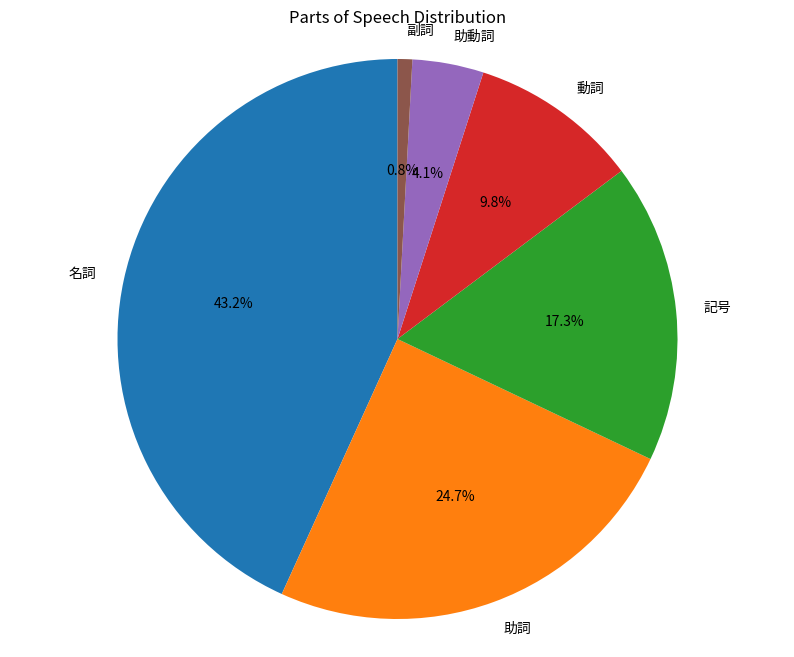

In [17]:
# 円グラフで可視化
top_pos = pos_counts.most_common(6)
labels = [p[0] for p in top_pos]
sizes = [p[1] for p in top_pos]

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Parts of Speech Distribution')
plt.axis('equal')
plt.show()

---
## 9. ワードクラウド生成

単語の出現頻度を視覚的に表現するワードクラウドを生成します。

ワードクラウドでは：
- 出現頻度が高い単語ほど大きく表示
- 色はカラーマップに基づいてランダムに割り当て

In [18]:
def find_japanese_font() -> str:
    """
    利用可能な日本語フォントを探す
    
    Returns:
        フォントファイルのパス（見つからない場合はNone）
    """
    font_paths = [
        # ChromeOS / Linux
        '/usr/share/fonts/chromeos/notocjk/NotoSansCJK-Regular.ttc',
        '/usr/share/fonts/chromeos/notocjk/NotoSansCJK-Bold.ttc',
        '/usr/share/fonts/chromeos/notocjk/NotoSansCJK-Light.ttc',
        '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc',
        '/usr/share/fonts/noto-cjk/NotoSansCJK-Regular.ttc',
        # IPAフォント
        '/usr/share/fonts/ipa-gothic/ipag.ttf',
        '/usr/share/fonts/truetype/ipa-gothic/ipag.ttf',
        # macOS
        '/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc',
        '/Library/Fonts/Arial Unicode.ttf',
        # Windows
        'C:/Windows/Fonts/msgothic.ttc',
        'C:/Windows/Fonts/meiryo.ttc',
    ]
    
    for font_path in font_paths:
        if Path(font_path).exists():
            return font_path
    return None

# フォントを検索
font_path = find_japanese_font()
if font_path:
    print(f"使用フォント: {font_path}")
else:
    print("警告: 日本語フォントが見つかりません")

使用フォント: /usr/share/fonts/chromeos/notocjk/NotoSansCJK-Regular.ttc


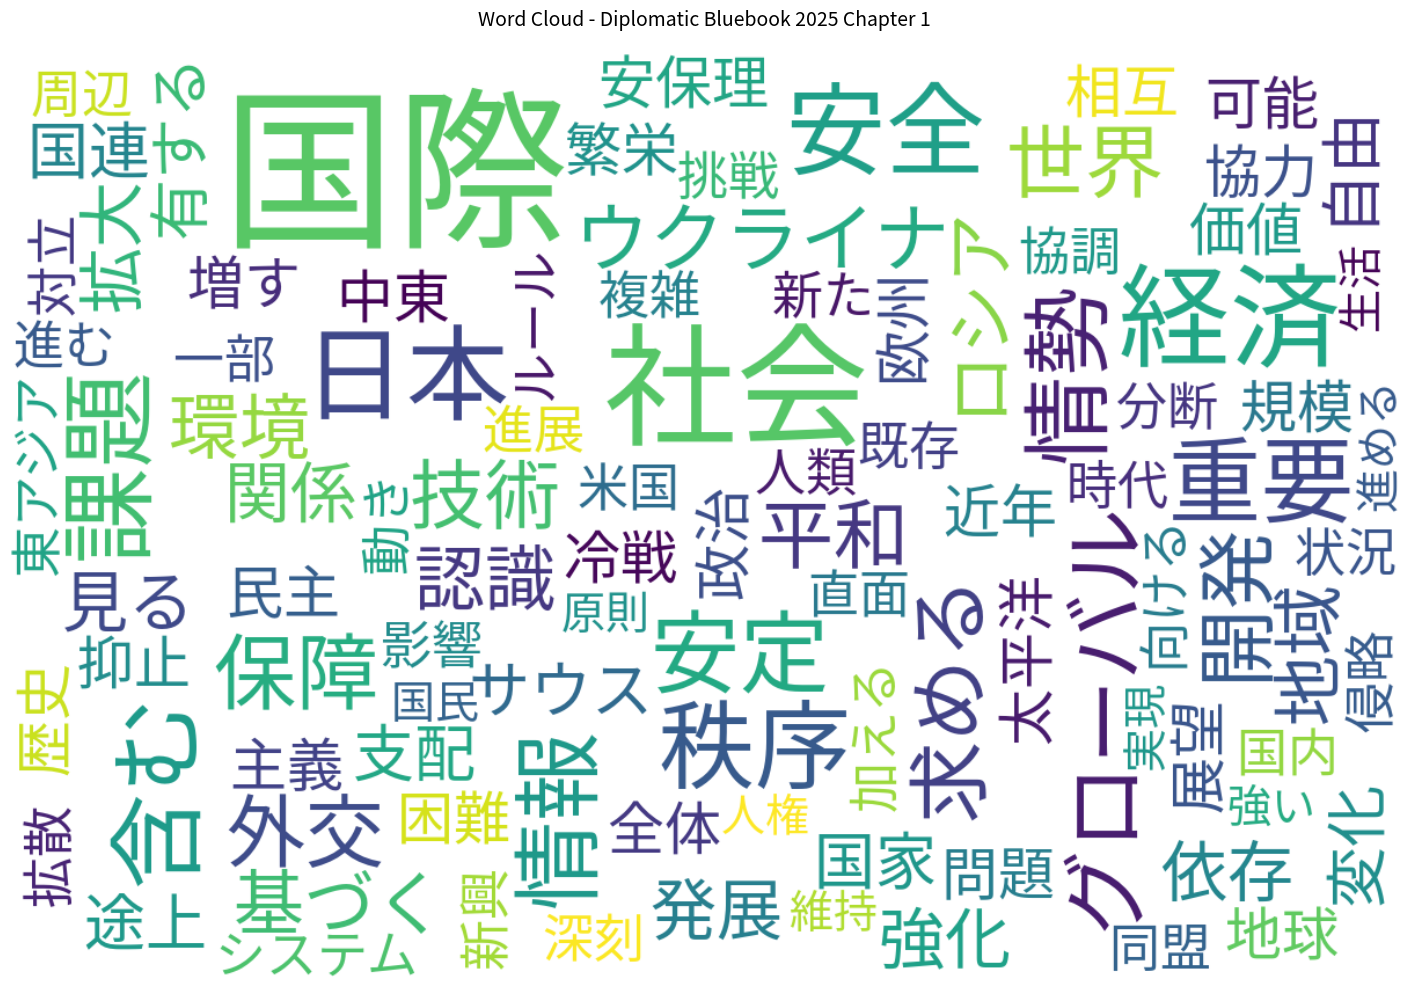

In [19]:
# ワードクラウドの生成
wc = WordCloud(
    font_path=font_path,
    **WORDCLOUD_CONFIG
)

# 単語頻度からワードクラウドを生成
word_freq_dict = dict(word_counts)
wc.generate_from_frequencies(word_freq_dict)

# 表示
plt.figure(figsize=(16, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Diplomatic Bluebook 2025 Chapter 1', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [20]:
# ワードクラウド画像を保存
plt.figure(figsize=(16, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig(OUTPUT_IMAGE, dpi=150, bbox_inches='tight', facecolor='white', pad_inches=0.1)
plt.close()

print(f"ワードクラウドを保存しました: {OUTPUT_IMAGE}")

ワードクラウドを保存しました: wordcloud.png


---
## 10. 結果の保存

分析結果をCSVファイルに保存します。

In [21]:
# 頻度分析結果をCSVに保存
with open(OUTPUT_CSV, 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['順位', '単語', '出現回数'])
    for rank, (word, count) in enumerate(word_counts.most_common(), 1):
        writer.writerow([rank, word, count])

print(f"頻度分析結果を保存しました: {OUTPUT_CSV}")
print(f"保存単語数: {len(word_counts)} 語")

頻度分析結果を保存しました: word_frequency_results.csv
保存単語数: 586 語


---
## 11. 分析結果のまとめ

外交青書2025 第1章の分析結果をまとめます。

In [22]:
# 分析結果のサマリー
print("=" * 60)
print("分析結果サマリー")
print("=" * 60)
print(f"\n【基本統計】")
print(f"  抽出文字数: {len(raw_text):,} 文字")
print(f"  総単語数: {len(words):,} 語")
print(f"  ユニーク単語数: {len(word_counts):,} 語")
print(f"  共起ペア数: {len(cooccurrence):,} ペア")

print(f"\n【上位10語】")
for rank, (word, count) in enumerate(word_counts.most_common(10), 1):
    print(f"  {rank:2}. {word}: {count}回")

print(f"\n【共起頻度 上位5ペア】")
for rank, (pair, count) in enumerate(cooccurrence.most_common(5), 1):
    print(f"  {rank}. {pair[0]} - {pair[1]}: {count}回")

print(f"\n【出力ファイル】")
print(f"  - {OUTPUT_CSV}: 単語頻度データ")
print(f"  - {COOCCURRENCE_CSV}: 共起分析データ")
print(f"  - {OUTPUT_IMAGE}: ワードクラウド画像")

print("\n" + "=" * 60)
print("分析完了")
print("=" * 60)

分析結果サマリー

【基本統計】
  抽出文字数: 6,547 文字
  総単語数: 1,387 語
  ユニーク単語数: 586 語
  共起ペア数: 445 ペア

【上位10語】
   1. 国際: 56回
   2. 社会: 29回
   3. 経済: 20回
   4. 日本: 17回
   5. 安全: 16回
   6. 含む: 15回
   7. 秩序: 15回
   8. 課題: 15回
   9. 重要: 14回
  10. 情勢: 13回

【共起頻度 上位5ペア】
  1. 国際 - 社会: 24回
  2. 国際 - 秩序: 12回
  3. 保障 - 安全: 11回
  4. 国際 - 情勢: 9回
  5. 国際 - 日本: 8回

【出力ファイル】
  - word_frequency_results.csv: 単語頻度データ
  - cooccurrence_results.csv: 共起分析データ
  - wordcloud.png: ワードクラウド画像

分析完了


---
## 付録: ストップワード一覧

本分析で使用したストップワードの一覧です。

In [23]:
# ストップワードをカテゴリ別に表示
stopword_categories = {
    '形式名詞': ['こと', 'もの', 'ため', 'よう'],
    '代名詞': ['これ', 'それ', 'あれ', 'ここ', 'そこ', 'あそこ', 'どこ', 'どれ', 'なに', '何'],
    '補助動詞': ['する', 'いる', 'ある', 'なる', 'れる', 'られる', 'せる', 'できる', 'おる', 'くる', '来る', '行く', 'いく'],
    '指示詞': ['この', 'その', 'あの', 'どの'],
    '否定': ['ない', 'なく'],
    '接尾辞': ['等', '的', '化', '性', '上', '中', '下', '内', '外'],
    '時間・番号': ['年', '月', '日', '号', '第', '章'],
    '接続詞等': ['ほか', 'また', 'および', 'かつ', 'ただし', 'なお', 'または']
}

print("ストップワード一覧")
print("=" * 50)
for category, words in stopword_categories.items():
    print(f"\n【{category}】")
    print(f"  {', '.join(words)}")

ストップワード一覧

【形式名詞】
  こと, もの, ため, よう

【代名詞】
  これ, それ, あれ, ここ, そこ, あそこ, どこ, どれ, なに, 何

【補助動詞】
  する, いる, ある, なる, れる, られる, せる, できる, おる, くる, 来る, 行く, いく

【指示詞】
  この, その, あの, どの

【否定】
  ない, なく

【接尾辞】
  等, 的, 化, 性, 上, 中, 下, 内, 外

【時間・番号】
  年, 月, 日, 号, 第, 章

【接続詞等】
  ほか, また, および, かつ, ただし, なお, または
